# Base

# Data Preprocessing

In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from bsts import BSTS
from keras.models import load_model
import seaborn as sns

## .1. Load DS

In [2]:
df = pd.read_csv('goldstock.csv')

print(df.head(5))

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True) # Convert Date column into a common format
df = df.sort_values('Date')
df.set_index('Date', inplace=True) # Set it as the index
df = df.drop('Index', axis=1)

print(f'The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.')

   Index        Date  Close/Last  Volume    Open    High     Low
0   2528  07/07/2014      1317.0   79110  1321.4  1321.7  1312.1
1   2527  08/07/2014      1316.5  126706  1320.8  1325.7  1314.3
2   2526  09/07/2014      1324.3  155101  1320.4  1333.4  1318.7
3   2525  10/07/2014      1339.2  167391  1325.0  1346.8  1325.0
4   2524  11/07/2014      1337.4   88470  1336.5  1340.4  1334.6
The dataset contains 2511 rows and 5 columns.


## .2. Handling Missing Values

In [3]:
# Check for missing values
print(df.isnull().sum())

Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64


## .3. Splitting the Dataset

In [4]:
# Train-test split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:] # train = first 8 years, test = last 2 years

# EDA

## .1. Histograms of Features

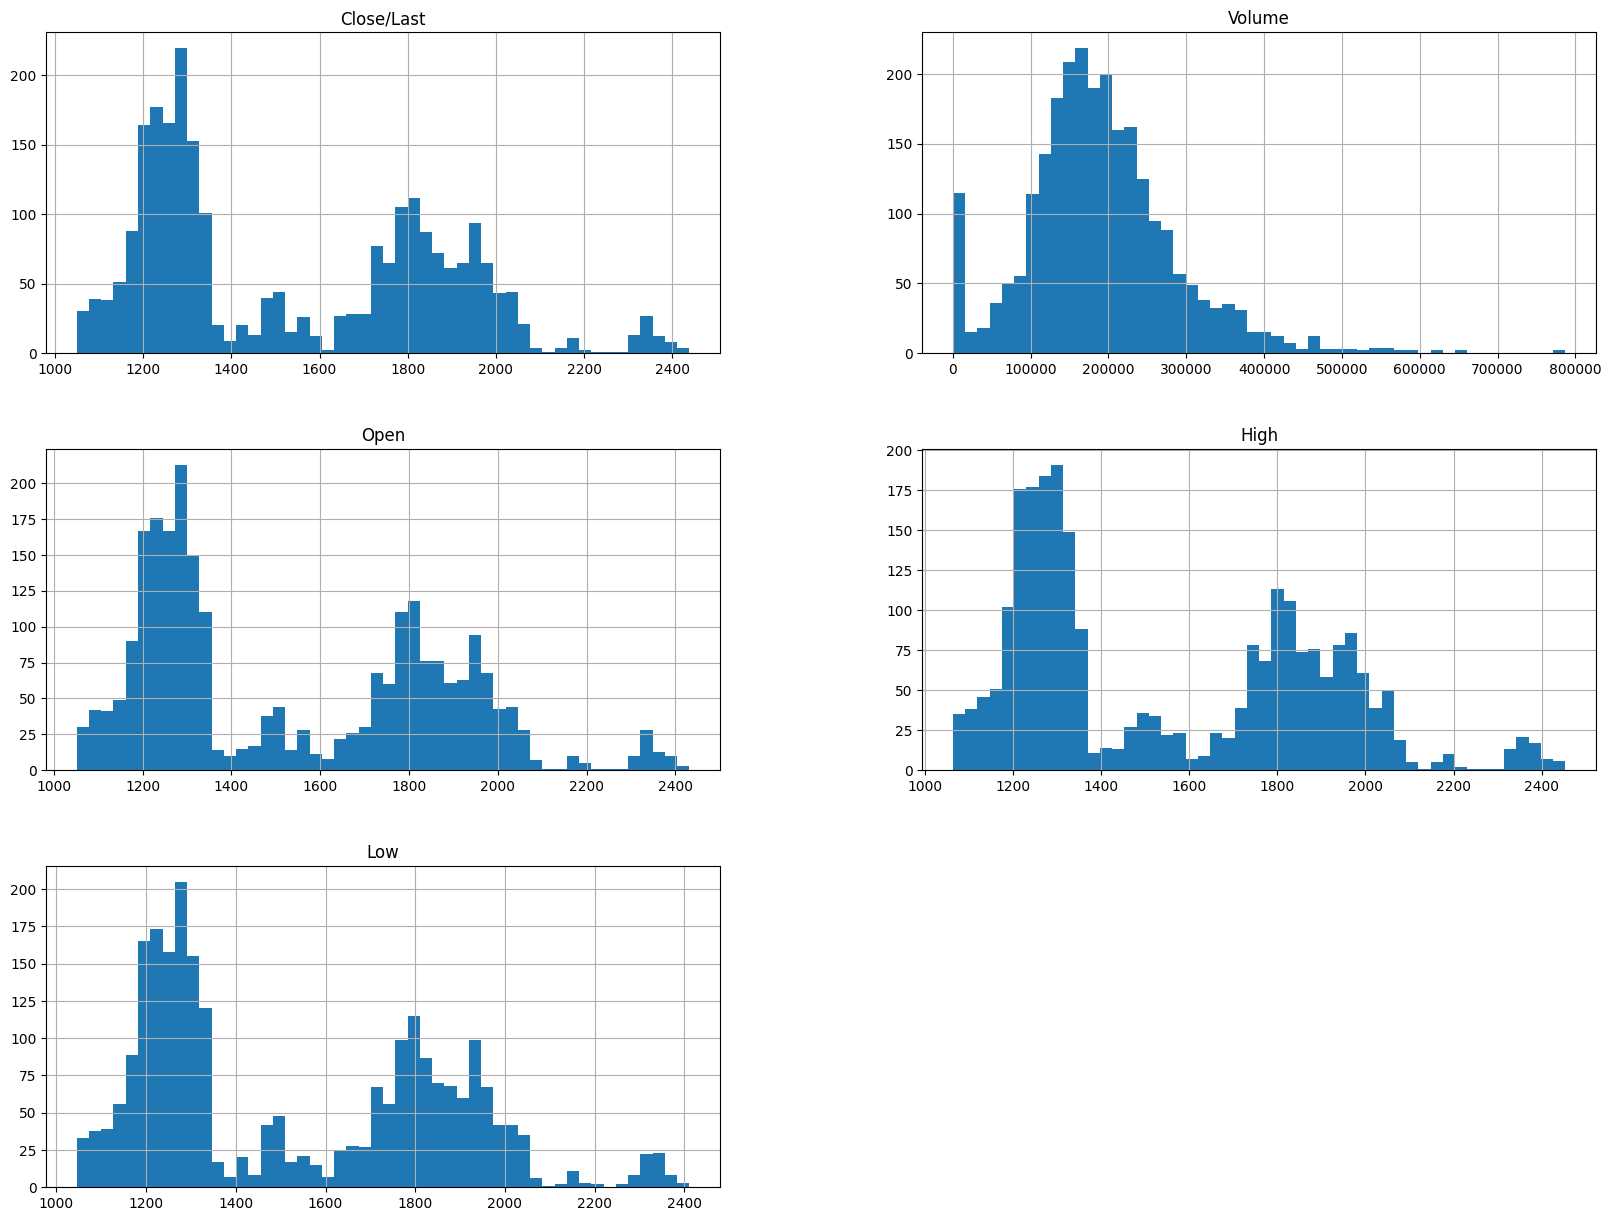

In [6]:
df.hist(bins=50, figsize=(20, 15))
plt.show()

## .2. Close Prices over Time

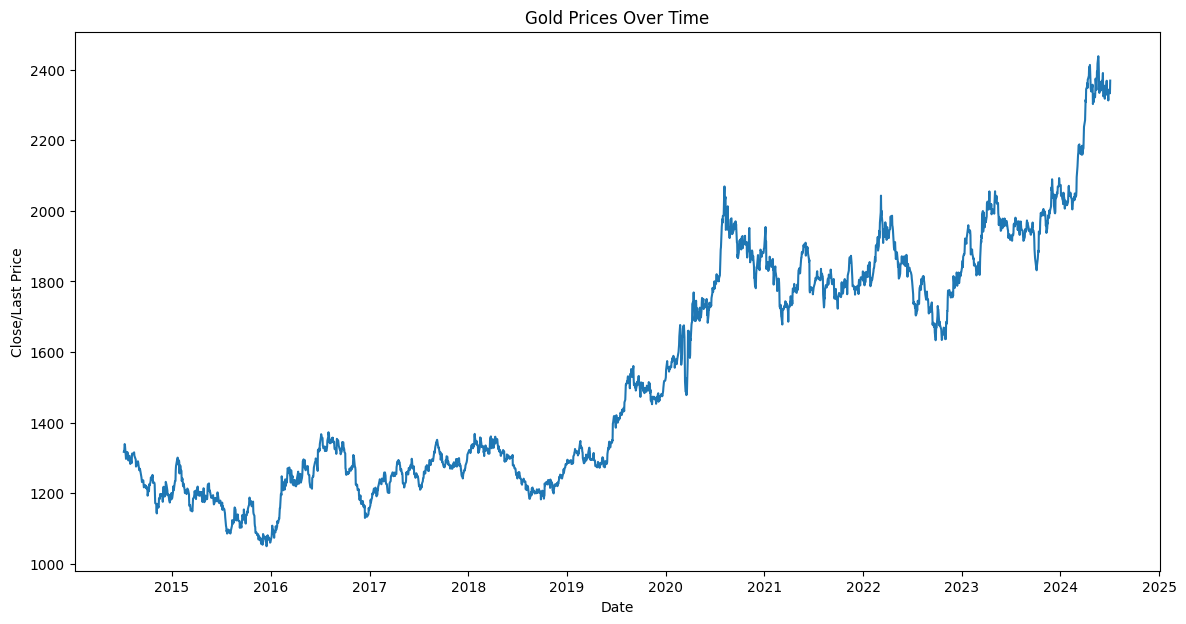

In [8]:
plt.figure(figsize=(14, 7))
plt.plot(df['Close/Last'])
plt.title('Gold Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close/Last Price')
plt.show()

## .3. Heatmap of the Correlation Matrix

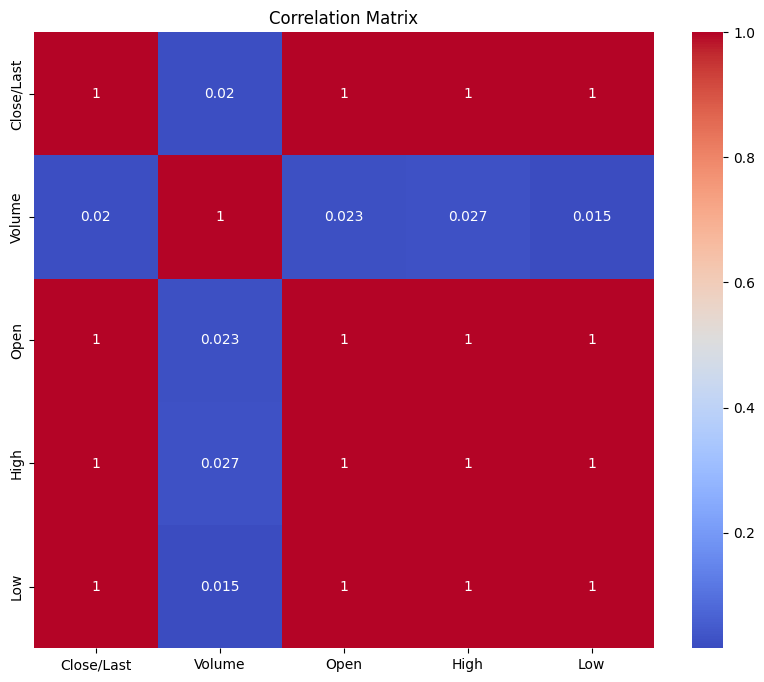

            Close/Last    Volume      Open      High       Low
Close/Last    1.000000  0.019551  0.999135  0.999589  0.999644
Volume        0.019551  1.000000  0.023158  0.027213  0.015087
Open          0.999135  0.023158  1.000000  0.999544  0.999473
High          0.999589  0.027213  0.999544  1.000000  0.999369
Low           0.999644  0.015087  0.999473  0.999369  1.000000


In [12]:
corr_matrix = df.corr()

# Plot the 
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

print(corr_matrix)

## .4. Pair Plots for Visualizing Feature Relationships

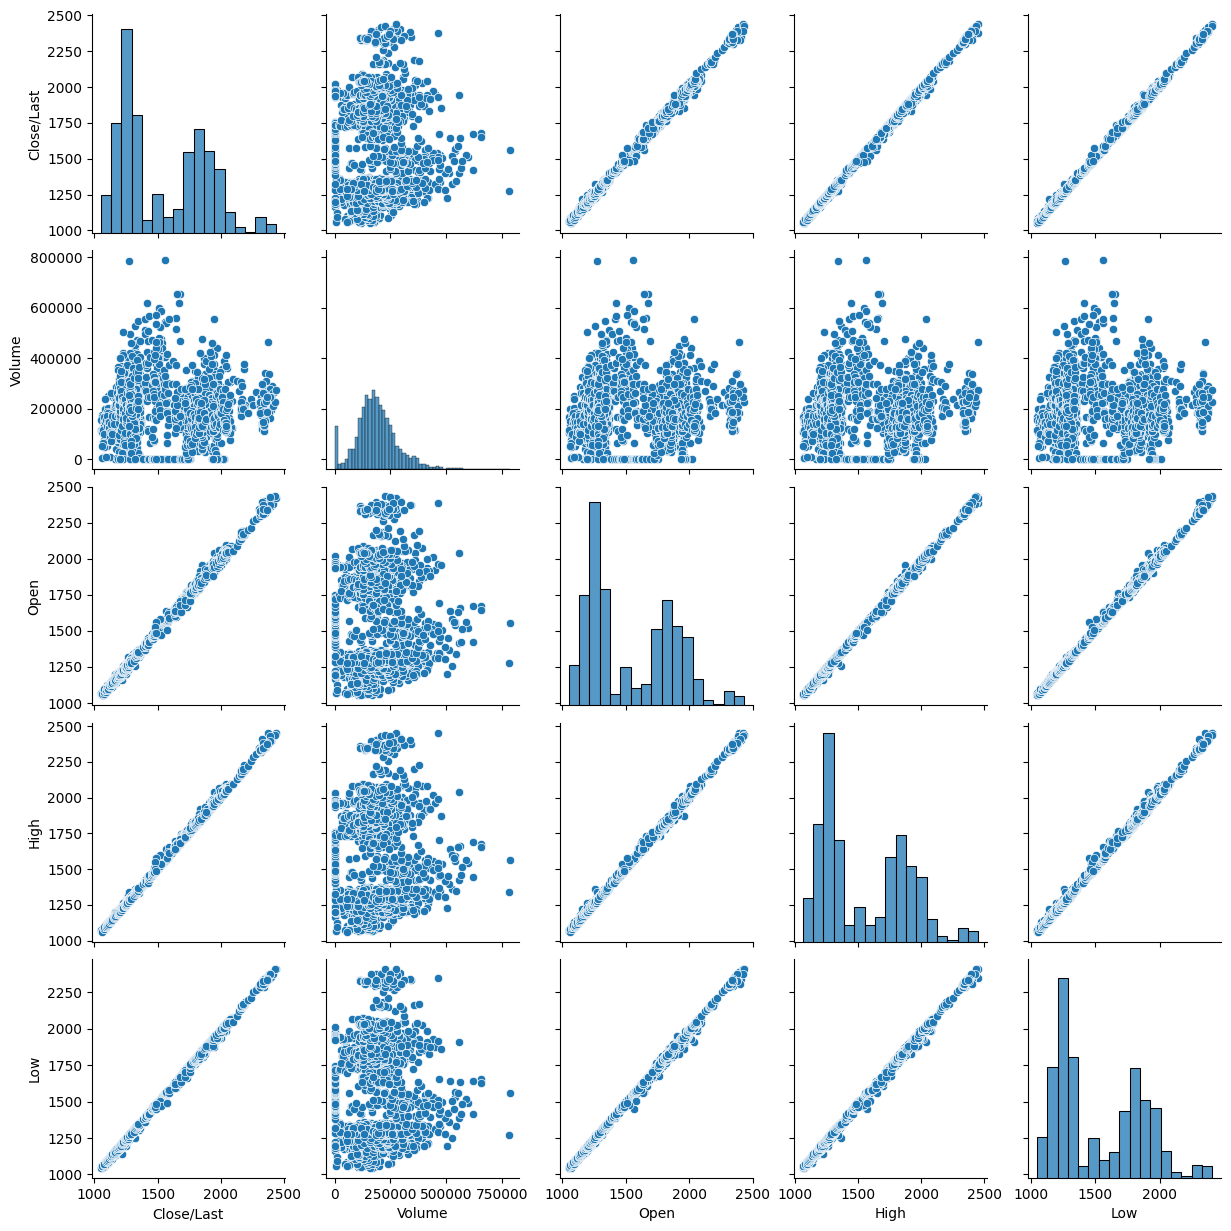

In [19]:
sns.pairplot(df)
plt.show()

## .5. Box Plot to Detect Outliers

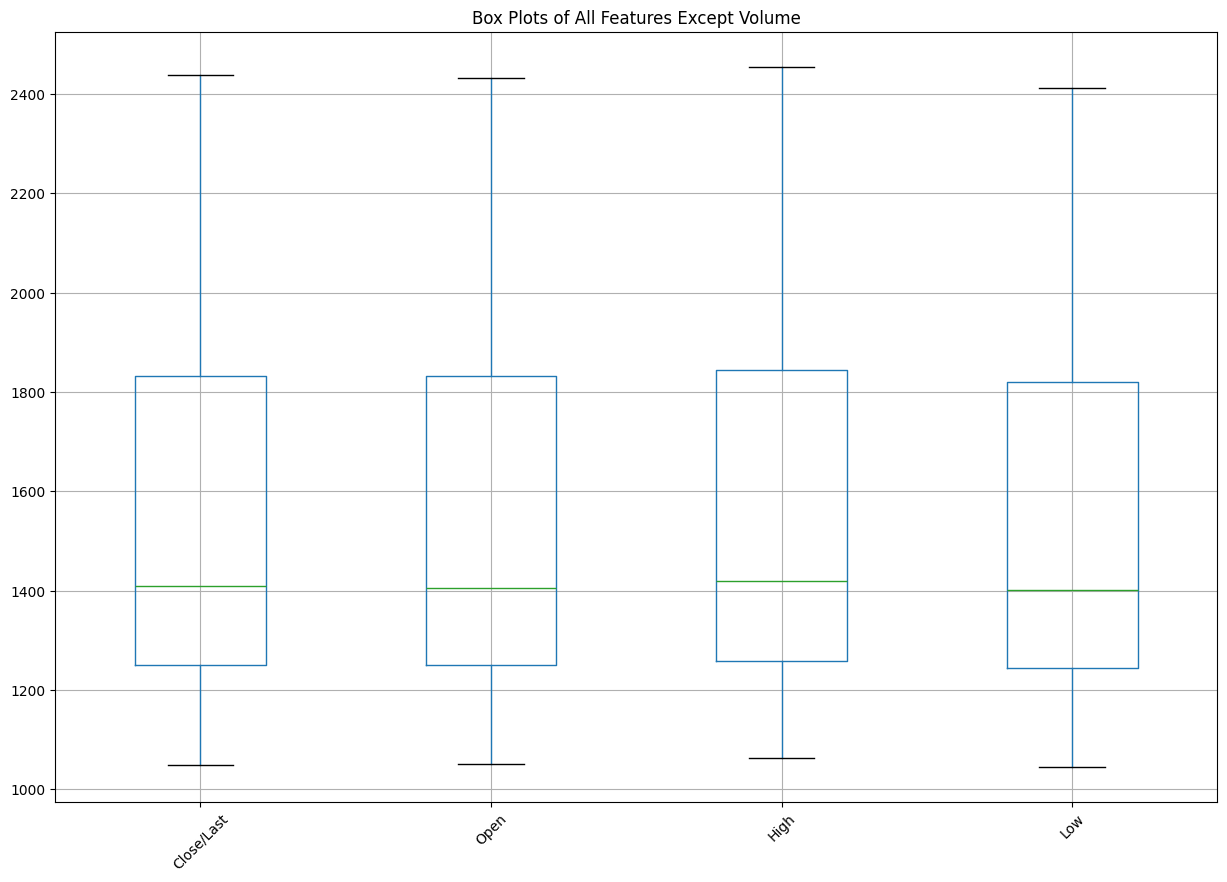

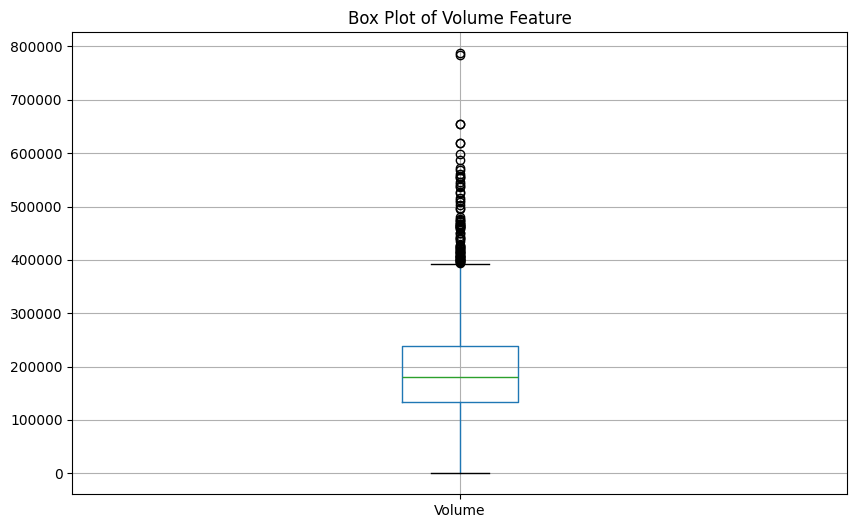

In [17]:
plt.figure(figsize=(15, 10))
df.boxplot(column=[col for col in df.columns if col != 'Volume'])
plt.title('Box Plots of All Features Except Volume')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
df.boxplot(column=['Volume'])
plt.title('Box Plot of Volume Feature')
plt.show()

## .6. Moving Averages

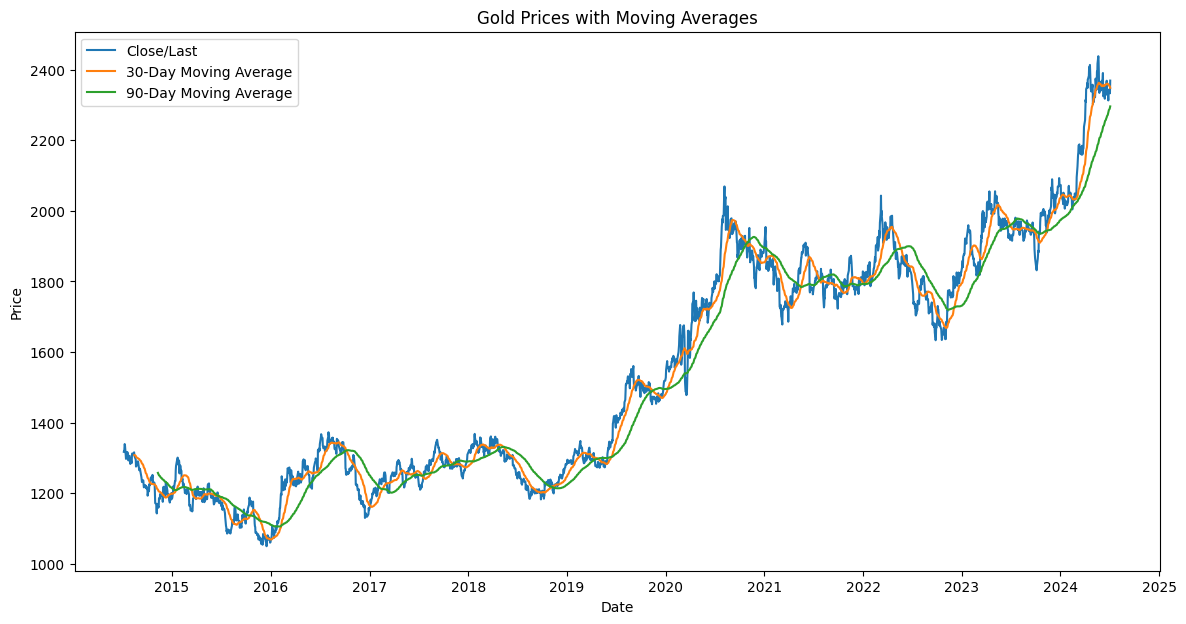

In [20]:
df['MA_30'] = df['Close/Last'].rolling(window=30).mean()
df['MA_90'] = df['Close/Last'].rolling(window=90).mean()

plt.figure(figsize=(14, 7))
plt.plot(df['Close/Last'], label='Close/Last')
plt.plot(df['MA_30'], label='30-Day Moving Average')
plt.plot(df['MA_90'], label='90-Day Moving Average')
plt.title('Gold Prices with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Feature Engineering

In [21]:
# Feature selection
features = ['Open']
X_train = train[features]
y_train = train['Close/Last']
X_test = test[features]
y_test = test['Close/Last']

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Model Selection

## .1. Prophet Model

In [22]:
def prophet_model(train, test):
    train_df = train.reset_index().rename(columns={'Date': 'ds', 'Close/Last': 'y'})
    test_df = test.reset_index().rename(columns={'Date': 'ds', 'Close/Last': 'y'})
    model = Prophet()
    model.fit(train_df[['ds', 'y']])
    future = test_df[['ds']]
    forecast = model.predict(future)
    y_pred = forecast['yhat'].values
    evaluate_model('Prophet', test_df['y'].values, y_pred)

## .2. Linear Regression Model

In [23]:
def linear_regression_model(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_model('Linear Regression', y_test, y_pred)

## .3. Random Forest Model

In [24]:

def random_forest_model(X_train, y_train, X_test, y_test):
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_model('Random Forest', y_test, y_pred)

## .4. XGBoost Model

In [25]:
def xgboost_model(X_train, y_train, X_test, y_test):
    model = xgb.XGBRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_model('XGBoost', y_test, y_pred)

## .5. LSTM Model

In [27]:
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)
    
def lstm_model(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.2, shuffle=False)

    y_pred_scaled = model.predict(X_test_seq)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_actual = scaler_y.inverse_transform(y_test_seq)
    evaluate_model('LSTM', y_test_actual, y_pred)


def lstm_pretrained_model(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, path):
    
    # Load the pre-trained model
    model = load_model(path)

    y_pred_scaled = model.predict(X_test_seq)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_actual = scaler_y.inverse_transform(y_test_seq)
    evaluate_model('LSTM', y_test_actual, y_pred)

# Model Training

In [28]:
# Function to evaluate and store results
results = {}
predictions = {}
def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    predictions[name] = y_pred
    print(f'{name} - MSE: {mse}, MAE: {mae}, R2: {r2}')

In [29]:
prophet_model(train, test)

22:56:54 - cmdstanpy - INFO - Chain [1] start processing
22:56:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet - MSE: 45495.06279289315, MAE: 162.31036549031757, R2: -0.23418277528830989


In [30]:
linear_regression_model(X_train_scaled, y_train, X_test_scaled, y_test)

Linear Regression - MSE: 276.761315010601, MAE: 12.398099302712678, R2: 0.9924920633826319


In [31]:
random_forest_model(X_train, y_train, X_test, y_test)

Random Forest - MSE: 15463.48015811895, MAE: 63.53237482722739, R2: 0.5805091874684869


In [32]:
xgboost_model(X_train, y_train, X_test, y_test)

XGBoost - MSE: 16405.238002555252, MAE: 63.68193660303803, R2: 0.554961331531084


In [33]:
path = "gold_price_prediction_model.h5"
lstm_pretrained_model(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, path)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
LSTM - MSE: 1037.0268547685444, MAE: 25.49753363495183, R2: 0.9717384560132398


# Model Evaluation

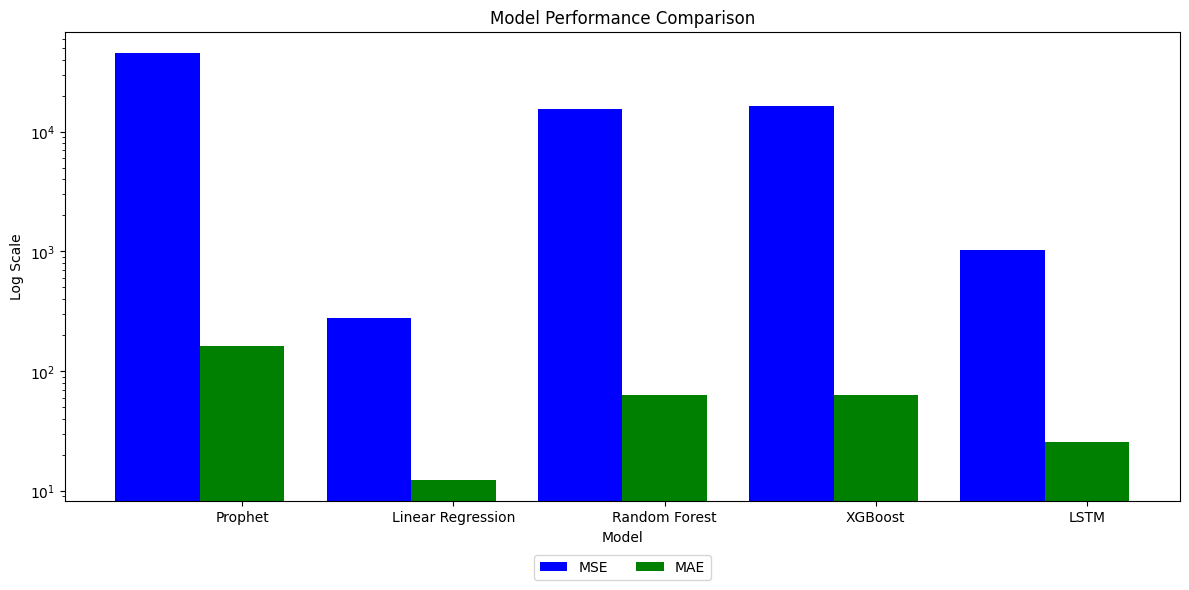

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the results
metrics = ['MSE', 'MAE']
colors = ['b', 'g']

fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.4
index = np.arange(len(results))

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in results]
    ax.bar(index + i * bar_width, values, bar_width, label=metric, color=colors[i])

ax.set_xlabel('Model')
ax.set_ylabel('Log Scale')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(results.keys())
ax.set_yscale('log')  # Set y-axis to log scale
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(metrics))

plt.tight_layout()
plt.show()

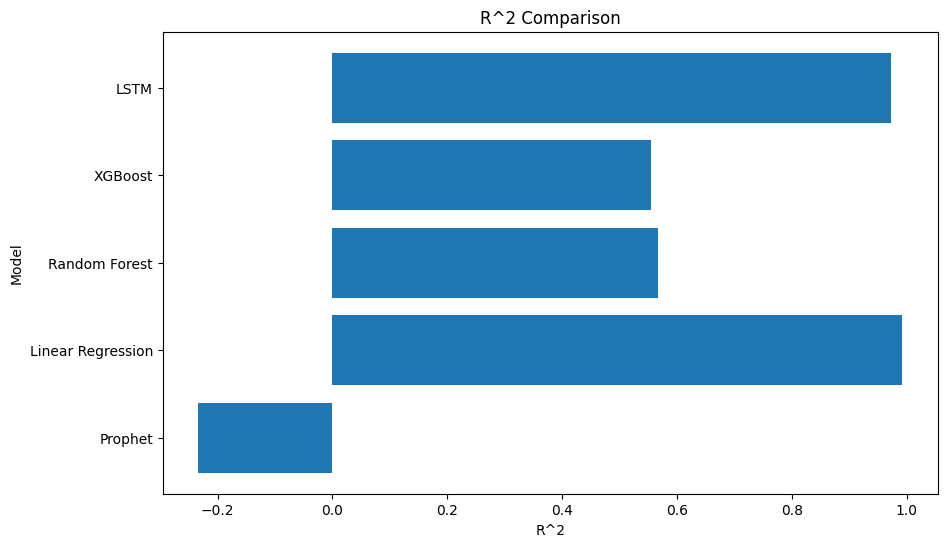

In [57]:
# Plot the R^2 separately in a horizontal bar setup
plt.figure(figsize=(10, 6))
plt.barh(list(results.keys()), [results[model]['R2'] for model in results])
plt.title('R^2 Comparison')
plt.xlabel('R^2')
plt.ylabel('Model')
plt.show()

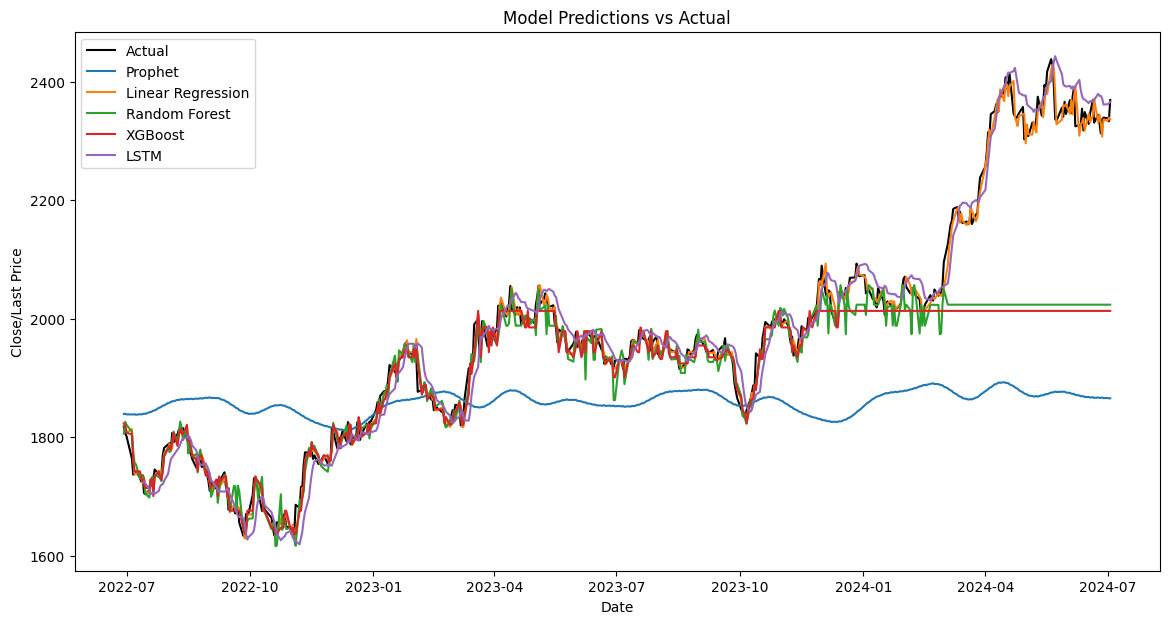

In [35]:
def plot_predictions(test, predictions):
    plt.figure(figsize=(14, 7))
    plt.plot(test.index, test.values, label='Actual', color='black')
    for model_name, y_pred in predictions.items():
        # Adjust the length of the test set to match the length of the predictions
        if len(y_pred) < len(test):
            plt.plot(test.index[-len(y_pred):], y_pred, label=model_name)
        else:
            plt.plot(test.index, y_pred, label=model_name)
    plt.xlabel('Date')
    plt.ylabel('Close/Last Price')
    plt.title('Model Predictions vs Actual')
    plt.legend()
    plt.show()


plot_predictions(test['Close/Last'], predictions)

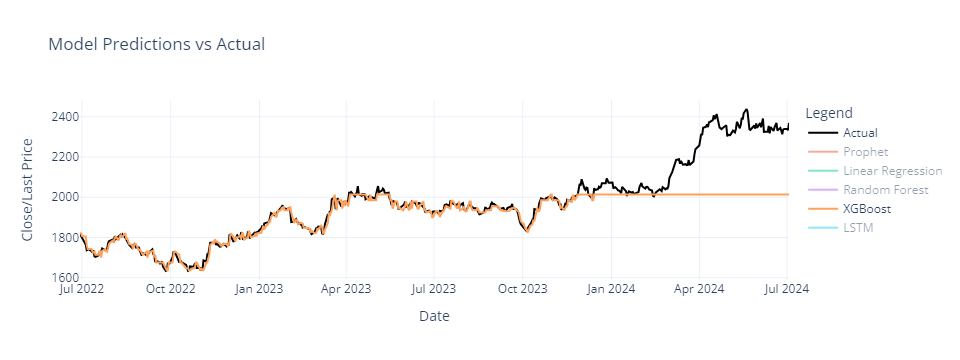

In [59]:
import plotly.graph_objects as go

# Plotting function using Plotly
def plot_predictions(test, predictions):
    fig = go.Figure()

    # Add actual values
    fig.add_trace(go.Scatter(x=test.index, y=test.values, mode='lines', name='Actual', line=dict(color='black')))

    # Add predictions for each model
    for model_name, y_pred in predictions.items():
        if len(y_pred) < len(test):
            x_values = test.index[-len(y_pred):]
        else:
            x_values = test.index
        fig.add_trace(go.Scatter(x=x_values, y=y_pred.flatten(), mode='lines', name=model_name))

    # Update layout
    fig.update_layout(
        title='Model Predictions vs Actual',
        xaxis_title='Date',
        yaxis_title='Close/Last Price',
        legend_title='Legend',
        template='plotly_white'
    )

    fig.show()

# Plot predictions
plot_predictions(test['Close/Last'], predictions)